In [1]:
import pandas as pd
import os
from collections import Counter, defaultdict
import json
import pandas as pd
pd.options.mode.chained_assignment = None
from tqdm import tqdm
import numpy as np
import regex as re
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity, paired_distances
import numpy as np
np.random.seed(0)

from tqdm import tqdm
import random

# libraries & dataset
import seaborn as sns
import matplotlib.pyplot as plt
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set_theme(style="white", palette="pastel")
import scipy
import json

from scipy import sparse

import time
import gc

from sklearn.manifold import TSNE

### 读取高被引论文

In [2]:
data_dir = '2021-07-19'

In [3]:
# 高被引论文
top_cited_papers_dict = {}
for file in os.listdir('scibert编码文章/top_cited'):
    if file.endswith(f'_{data_dir}.tsv'):
        month = file.split('.')[0].split('_')[-2]
        df = pd.read_csv(os.path.join('scibert编码文章/top_cited',file),sep='\t')
        top_cited_papers_dict[str(month)] = df

In [6]:
top_cited_papers_dict['2020-03']

,cited_paper,uid,count
0,Clinical features of patients infected with 20...,m2lq1qnp,117.0
1,Epidemiological and clinical characteristics o...,cxw5nv7d,67.0
2,A novel coronavirus from patients with pneumon...,NaN,64.0
3,A pneumonia outbreak associated with a new cor...,d5yt2fih,54.0
4,Genomic characterisation and epidemiology of 2...,ru8dtoaa,41.0
5,A familial cluster of pneumonia associated wit...,j3avpu1y,34.0
6,First case of 2019 novel coronavirus in the Un...,NaN,32.0
7,A new coronavirus associated with human respir...,69touqca,29.0
8,Remdesivir and chloroquine effectively inhibit...,r22x7gnu,20.0
9,"Early transmission dynamics in Wuhan, China, o...",NaN,19.0


In [4]:
# set(top_cited_papers_dict['2020-01']['uid'])

In [5]:
# set(top_cited_papers_dict['2020-02']['uid'])

In [6]:
# set(top_cited_papers_dict['2020-03']['uid'])

In [4]:
# 所有论文的embedding
title_embs_df = pd.read_csv(f'scibert编码文章/title_embs_df_{data_dir}.csv',index_col=0)
abstract_embs_df = pd.read_csv(f'scibert编码文章/abstract_embs_df_{data_dir}.csv',index_col=0)
paper_emb = title_embs_df.join(abstract_embs_df,lsuffix='_ti',rsuffix='_ab')
uid_map = {uid:i for i,uid in enumerate(title_embs_df.index)}
X = paper_emb.values

# title_embs_df = pd.read_csv(f'scibert编码文章/title_embs_df_{data_dir}.csv',index_col=0)
# abstract_embs_df = pd.read_csv(f'scibert编码文章/abstract_embs_df_{data_dir}.csv',index_col=0)
# paper_emb = abstract_embs_df
# uid_map = {uid:i for i,uid in enumerate(title_embs_df.index)}
# X = paper_emb.values

In [5]:
# 所有论文的元数据
paper_self_info = pd.read_csv(f'指标初步探索/paper_self_info_{data_dir}_scibert.csv',
           dtype={'citing_paper':'object','cord_uid':'object',
#                   'citing_year':'object','citing_month':'object','citing_date':'object',
                  'citing_year_month':'object',
                  'min_cos_distance':'float','mean_cos_distance':'float',
                })

In [6]:
visualized_papers = paper_self_info.loc[paper_self_info['citing_year_month'].isin(['2020-01','2020-02'])] # ,'2020-03'

In [7]:
visualized_papers_embs = paper_emb.loc[visualized_papers.cord_uid]

In [8]:
X_tsne = TSNE(n_components=2,perplexity=5,learning_rate=50,metric='cosine',n_jobs=-1).fit_transform(visualized_papers_embs.values)

c:\users\86187\appdata\local\programs\python\python37\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\users\86187\appdata\local\programs\python\python37\lib\site-packages\sklearn\manifold\_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


In [9]:
visualized_papers['top_cited_1'] = 0
visualized_papers['top_cited_2'] = 0
visualized_papers['top_cited_3'] = 0
visualized_papers['top_cited_4'] = 0
visualized_papers['publish_time'] = 0

In [10]:
visualized_papers = visualized_papers[['cord_uid','citing_paper','citing_year_month','publish_time','top_cited_1','top_cited_2','top_cited_3','top_cited_4']]

In [11]:
visualized_papers['publish_time'] = visualized_papers['citing_year_month'].map(lambda x:x[-1]).astype(int)

In [12]:
for i in range(1,5):
    top_cited = []
    for uid,publish_time in zip(visualized_papers['cord_uid'],visualized_papers['publish_time']):
        if uid in set(top_cited_papers_dict[f'2020-0{i}']['uid']):
            top_cited.append(1)
        else:
            top_cited.append(0)
    visualized_papers[f'top_cited_{i}'] = top_cited

In [13]:
visualized_papers

,cord_uid,citing_paper,citing_year_month,publish_time,top_cited_1,top_cited_2,top_cited_3,top_cited_4
11,dei0xd1b,COVID-19: Zoonotic aspects,2020-02,2,0,0,0,0
67,sp7ctspl,A Novel Approach of Consultation on 2019 Novel...,2020-02,2,0,0,0,0
130,jbwvzq8o,Anxiety among Doctors during COVID-19 Pandemic...,2020-01,1,0,0,0,0
138,e36l3t1g,A Fourteen-day Experience with Coronavirus Dis...,2020-01,1,0,0,0,0
169,vtjsigod,Novel coronavirus infection during the 2019–20...,2020-02,2,0,0,0,0
...,...,...,...,...,...,...,...,...
47379,6zlxqhuq,Communicating the Risk of Death from Novel Cor...,2020-02,2,0,0,0,0
47499,4ikxmpyn,NLRP3 Inflammasome—A Key Player in Antiviral R...,2020-02,2,0,0,0,0
47552,eelqmzdx,Influential Nodes Identification in Complex Ne...,2020-02,2,0,0,0,0
47564,wgs69cu6,Ultrasensitive haptoglobin biomarker detection...,2020-01,1,0,0,0,0


In [24]:
X_tsne[visualized_papers['top_cited_3'].values == 1]

array([[-16.85617  ,  56.345203 ],
       [-42.079193 ,  42.324745 ],
       [ 52.88314  ,  -2.5478728]], dtype=float32)

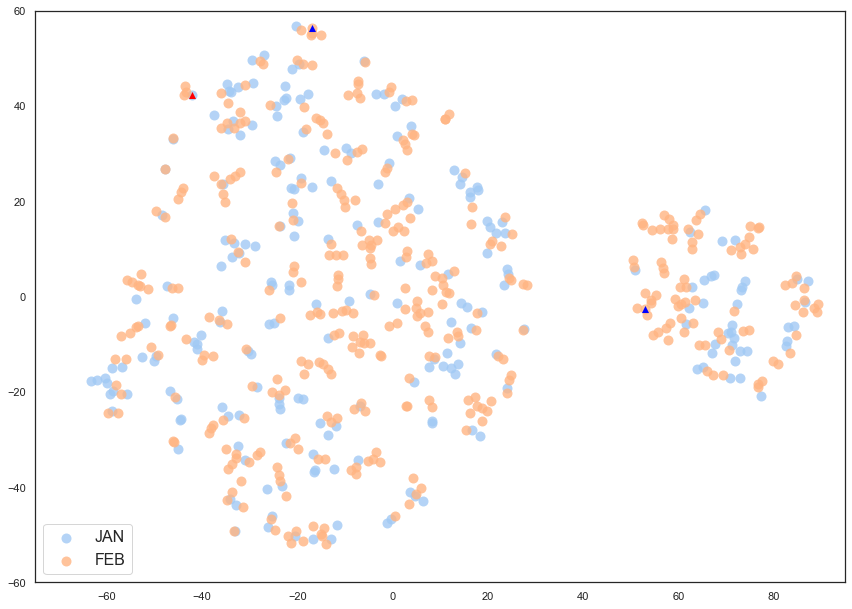

In [20]:
# colors = ['lightsteelblue','palegreen','pink']
fig,ax = plt.subplots(figsize=(12,15))

my_x_ticks = np.arange(-90, 70, 10)#原始数据有13个点，故此处为设置从0开始，间隔为1
# ax.set_xticks(my_x_ticks)
# ax.set_yticks(my_x_ticks)
plt.xlim(-75, 95)
plt.ylim(-60, 60)

for i in range(1,3):
    if i == 1:
        label = 'JAN'
    if i == 2:
        label ='FEB'
    cords = X_tsne[visualized_papers['publish_time'].values == i]
    x,y = cords[:,0],cords[:,1]
    ax.scatter(x,y,marker='o',  linewidths=0, label = label, s=100, alpha=0.8) # c=colors[i-1],
    

drawed_cords = set()
for i in range(1,4):
    cords = X_tsne[visualized_papers[f'top_cited_{i}'].values == 1]
    x,y = cords[:,0],cords[:,1]
    if i == 2:
        for x_, y_ in zip(x,y):
            if (x_, y_) in drawed_cords:
                continue
            drawed_cords.add((x_,y_))
            ax.scatter(x_,y_,marker='^', c='red', linewidths=0, s=50)
    if i == 3:
        for x_, y_ in zip(x,y):
            if (x_, y_) in drawed_cords:
                continue
            drawed_cords.add((x_,y_))
            ax.scatter(x_,y_,marker='^', c='blue', linewidths=0, s=50)

# cord_dict = defaultdict(int)
# for i in range(2,4):
#     cords = X_tsne[visualized_papers[f'top_cited_{i}'].values == 1]
#     x,y = cords[:,0],cords[:,1]
    
#     for sx,sy in zip(x,y):
#         cord_dict[(sx,sy)] += 2
#         print(sx,sy)
#         ax.text(sx+cord_dict[(sx,sy)],sy,f"{i}",fontsize=15)
#         if i == 3:
#             print(sx ,sy)
#             ax.add_patch(plt.Circle((-42.079193,42.324745),30.438667608675843,fill=False, color='red', alpha=0.6))
#             ax.add_patch(plt.Circle((-42.079193,42.324745),118.57804053754063,fill=False, color='red', alpha=0.6)) # 

# plt.text(-60,40,'≈ 19.20%',fontsize=16,c='red')
# plt.text(55,-30,'≈ 13.47%',fontsize=16,c='red')
# plt.text(-50,-40,'≈ 67.33%',fontsize=16,c='red')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='lower left',fontsize=16)
plt.tight_layout()
plt.savefig('top_paper_case.svg')

In [69]:
(np.hstack([np.linalg.norm(X_tsne[visualized_papers['publish_time'].values == 1] - np.array([64.21386,2.0024853]),axis=1),
np.linalg.norm(X_tsne[visualized_papers['publish_time'].values == 2] - np.array([64.21386,2.0024853]),axis=1)])<30.43866760867584).sum()/594

0.13468013468013468

In [64]:
np.hstack([np.linalg.norm(X_tsne[visualized_papers['publish_time'].values == 1] - np.array([64.21386,2.0024853]),axis=1),
np.linalg.norm(X_tsne[visualized_papers['publish_time'].values == 2] - np.array([64.21386,2.0024853]),axis=1)]).shape

(594,)

In [19]:
# # colors = ['royalblue','forestgreen','crimson']
# for i in range(1,5):
#     cords = X_tsne[visualized_papers['top_cited'].values == i]
#     x,y = cords[:,0],cords[:,1]
#     plt.scatter(x,y,marker='o', c='red', linewidths=0,edgecolors='red',)
# plt.legend()